# Quick Analysis of COVID-19 confirmed cases data

I've been quite frustrated with the data showing raw cases.  I'm much more interested in how many cases there are compared with the total population of a country or region.  The following adjusts the latest confirmed cases data to adjust for the total population of the country or region.  All numbers are percentages, and as you can tell, they are quite small at the moment.  But it's helpful for comparisons.

Data was sourced from: https://github.com/CSSEGISandData/COVID-19

Last Updated: 2020-03-26

In [1]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dateparser
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
pop_filename='./general_data/world-pop.csv'
pop = pd.read_csv(pop_filename)
pop['region'] = pop['region'].fillna('')
pop['population'] = pop['population'].apply(float)
pop = pop.set_index(['country', 'region'])

In [3]:
filename='./output.csv'
df = pd.read_csv(filename, skiprows=0)
df = df.drop(columns=['Deaths', 'Recovered'])

df['region'] = df['region'].fillna('')
df = df.set_index(['country', 'region'])#, 'date'])
df['date'] = df['date'].apply(pd.to_datetime)
df = pd.merge(df, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
df['ratio'] = df['Confirmed']/df['population'] * 1000000.0
df = df.fillna(0)
df['Confirmed'] = df['Confirmed'].apply(int)
df = df.reset_index()
def by_country(df, names):
    df = df.loc[names]
    df = df.fillna(0)
    for d in df.columns:
        if d in ['country', 'population']:
            continue
        p = df['population'].apply(float)
        v = df[d]
        v = v.apply(float)
        v = v.divide(p)*100.0
        df[d] = v
    df = df.transpose()
    return df


# Latest Number of Confirmed Cases

In [4]:
areas_of_interest = [('US', 'Texas'), ('US', 'Utah'), ('Canada', 'British Columbia'), ('Canada','Ontario')]
pd.pivot_table(df, values='Confirmed', index=['date'],
                    columns=['country', 'region'], aggfunc=np.sum)[areas_of_interest].tail()

country         US                  Canada        
region       Texas   Utah British Columbia Ontario
date                                              
2020-03-22   643.0  162.0            424.0   425.0
2020-03-23   758.0  257.0            472.0   503.0
2020-03-24   955.0  298.0            617.0   588.0
2020-03-25  1229.0  340.0            617.0   688.0
2020-03-26  1563.0  396.0            725.0   858.0

# Canadian Provinces - Percentage of population confirmed

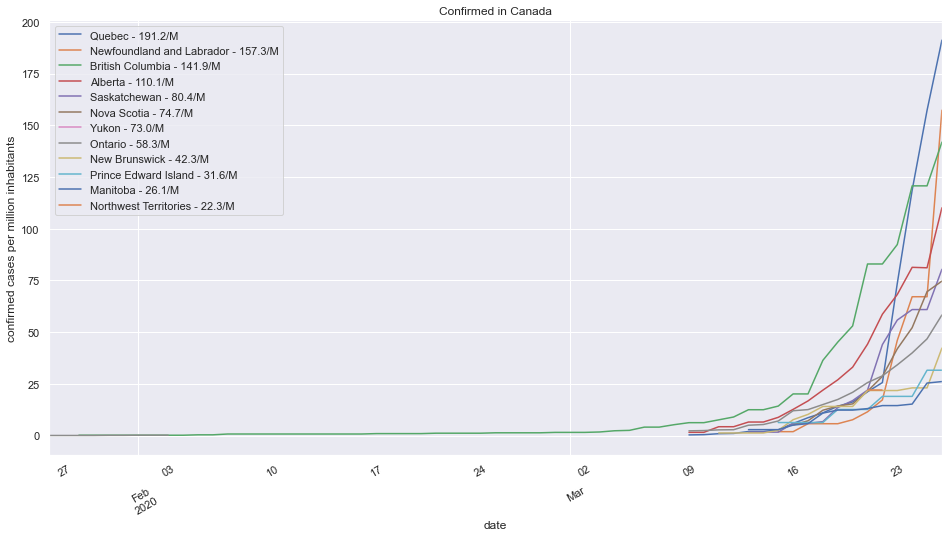

In [15]:
canada = df.loc[df['country'] == 'Canada']
canada = canada.drop(columns=['country'])

canada = canada.set_index(['date', 'region'])['ratio'].unstack(level=-1)
last_date = max(canada.index).date()
x = pd.DataFrame(canada.loc[last_date].fillna(0).sort_values(ascending=False))
canada = canada[x.index]

labels = list(map(lambda x: "%s - %.1f/M" % x, zip(x.index, x[x.columns[0]].to_list())))

ax = canada.plot(rot=30, figsize=(16,8), title='Confirmed in Canada')
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
ax.legend(labels)
pass

In [16]:
canada.tail()

region,Quebec,Newfoundland and Labrador,British Columbia,Alberta,Saskatchewan,Nova Scotia,Yukon,Ontario,New Brunswick,Prince Edward Island,Manitoba,Northwest Territories
date,,,,,,,,,,,,
2020-03-22,25.651015,17.262379,82.959672,58.688292,44.005667,28.645761,NaN,28.888322,21.795067,18.968373,14.518877,22.269731
2020-03-23,73.556334,46.033010,92.351333,68.205312,55.853346,41.945579,NaN,34.190179,21.795067,18.968373,14.518877,NaN
2020-03-24,118.650583,67.131472,120.721976,81.347864,60.930923,52.176208,NaN,39.967844,23.077130,18.968373,15.244821,NaN
2020-03-25,157.185669,67.131472,120.721976,81.121268,60.930923,69.568278,NaN,46.765096,23.077130,31.613956,25.408035,NaN
2020-03-26,191.152766,157.279449,141.853213,110.125520,80.394968,74.683592,73.031793,58.320425,42.308072,31.613956,26.133979,22.269731


# US States - Percentage of population confirmed

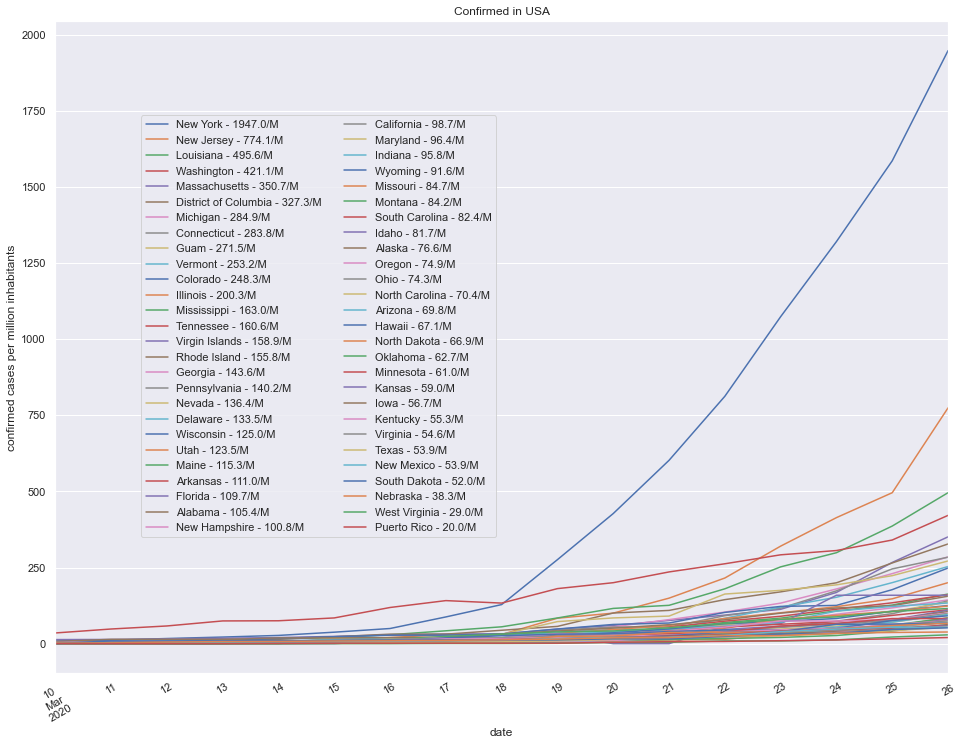

In [17]:
usa = df.loc[df['country'] == 'US'].loc[df['region'] != ''].groupby(by=['country', 'region', 'date']).sum()
last_date = str(max(usa.index.get_level_values(2)).date())
last_date
idx = pd.IndexSlice

x = usa.loc[idx[:,:,[last_date]], idx[['ratio', 'Confirmed', 'population']]].sort_values(by=['ratio'], ascending=False)
labels = list(map(lambda x: "%s - %.1f/M" % (x[0][1], x[1]), zip(x.index, x[x.columns[0]].to_list())))
rows = list(filter(lambda x: str(x[2]) > '2020-03-07', usa.index))
usa = usa.loc[rows]
usa = usa.reset_index()
usa = usa.drop(columns=['country'])

usa = pd.pivot_table(usa, values='ratio', index=['date'],
                     columns=['region'], aggfunc=np.sum).fillna(0)[x.index.get_level_values(1)]

ax = usa.plot(rot=30, figsize=(16,12), title='Confirmed in USA')
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
ax.legend(labels, bbox_to_anchor=(0.5, 0.2), ncol=2)
pass

# Percentage of Population Confirmed - Top 12 US States

In [18]:
x[:12][['Confirmed', 'ratio']]

Confirmed        ratio
country region               date                              
US      New York             2020-03-26      37877  1947.047124
        New Jersey           2020-03-26       6876   774.133406
        Louisiana            2020-03-26       2304   495.612410
        Washington           2020-03-26       3207   421.148400
        Massachusetts        2020-03-26       2417   350.670867
        District of Columbia 2020-03-26        231   327.311835
        Michigan             2020-03-26       2845   284.874410
        Connecticut          2020-03-26       1012   283.848117
        Guam                 2020-03-26         45   271.463732
        Vermont              2020-03-26        158   253.209592
        Colorado             2020-03-26       1430   248.318381
        Illinois             2020-03-26       2538   200.286920

# Top Countries Confirmed by Percentage of Population


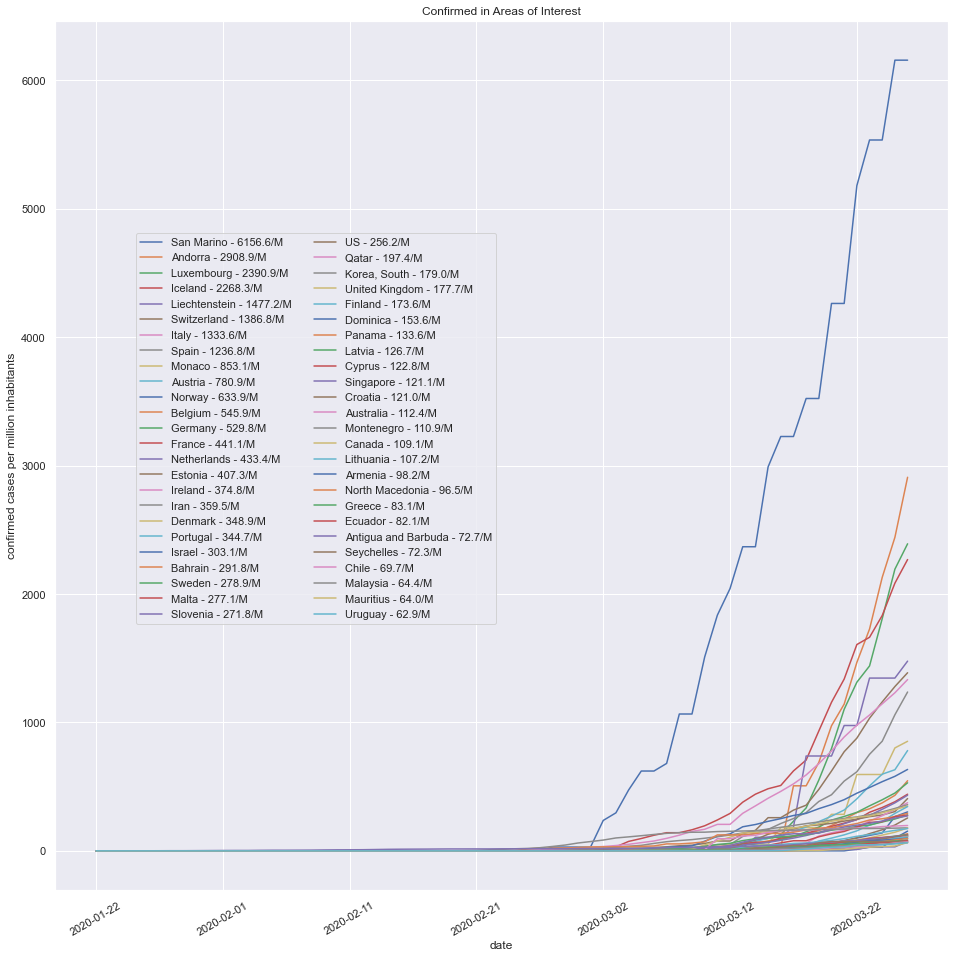

In [20]:
filename = "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
world = pd.read_csv(filename, skiprows=0)
world = world.drop(columns=['Lat', 'Long']).rename(columns={"Province/State": "region", "Country/Region": "country"})
world['region'] = world['region'].fillna("")
world = world.groupby(by=['country']).sum()
world['region'] = ""

world = pd.merge(world, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
world = world.drop(columns=['region'])
# rename columns
columns = dict([(d, str(dateparser.parse(d).date())) for d in world.columns if d not in ['population']])
world = world.rename(columns=columns)

world_pop = world.copy()

for d in world.columns:
    if d in ['country', 'population']:
        continue
    p = world['population']
    dd = str(dateparser.parse(d).date())
    world_pop[dd] = world[d].divide(p)*1000000.0
world = world.drop(columns=['population'])
world_pop = world_pop.drop(columns=['population'])
last_date = max(world_pop.columns)
world_pop = world_pop.sort_values(by=[last_date], ascending=False)
last = world_pop[last_date]

world_pop = world_pop.transpose()

countries = last[:50]
labels = list(map(lambda x: "%s - %.1f/M" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass


# Comparison of areas of interest - Percent of Population confirmed

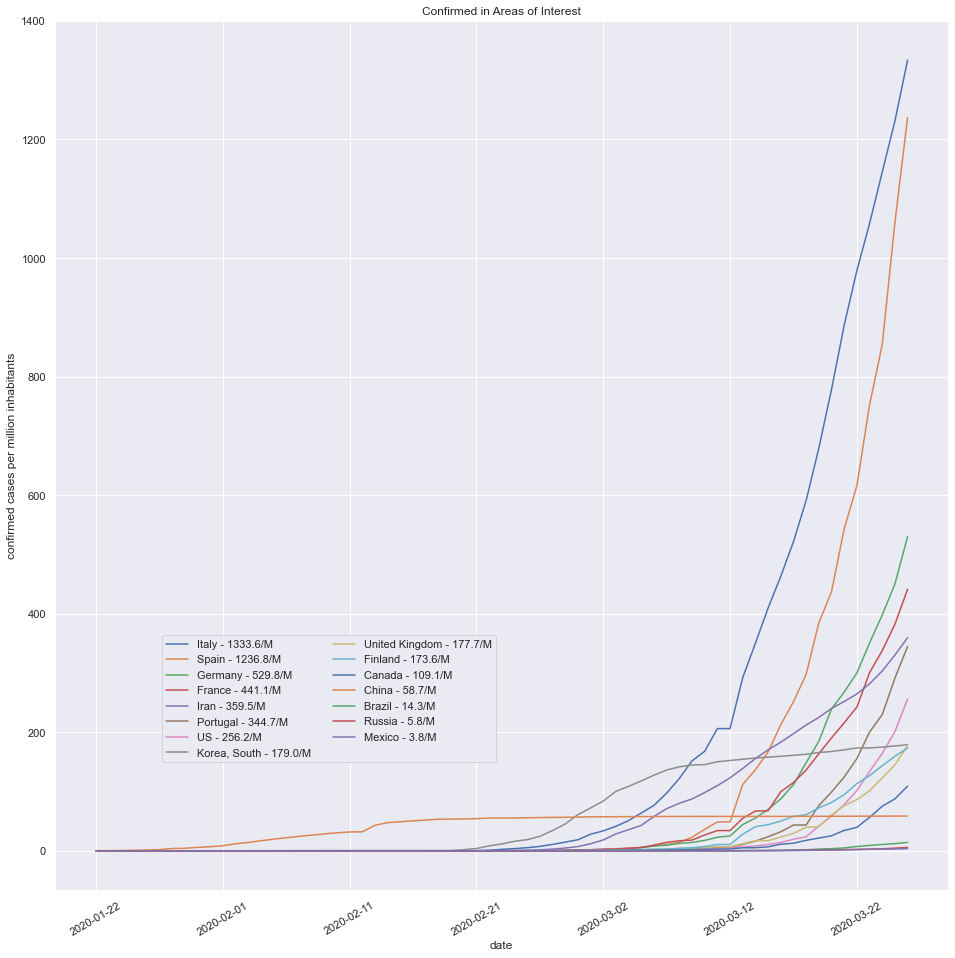

In [21]:
areas_of_interest = ['US', 'Canada', 'Iran', 'China', 'Korea, South', 'Italy', 'Spain',
                    'Germany', 'France', 'United Kingdom', 'Russia', 'Finland', 'Portugal',
                    'Brazil', 'Mexico']

areas = list(filter(lambda x: x in areas_of_interest, last.index))

countries = last[areas]
labels = list(map(lambda x: "%s - %.1f/M" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass

In [11]:
world_pop[countries.index].tail(6)

country,Italy,Spain,Germany,France,Iran,Portugal,US,"Korea, South",United Kingdom,Finland,Canada,China,Brazil,Russia,Mexico
2020-03-21,0.088659,0.054306,0.026786,0.021591,0.025196,0.012449,0.007791,0.017041,0.007621,0.009478,0.003446,0.005838,0.000487,0.000212,0.000161
2020-03-22,0.097860,0.061570,0.029994,0.024248,0.026452,0.015562,0.010171,0.017354,0.008641,0.011345,0.003964,0.005847,0.000738,0.000254,0.000199
2020-03-23,0.105785,0.075199,0.035038,0.030040,0.028177,0.020035,0.013402,0.017354,0.010116,0.012686,0.005634,0.005852,0.000919,0.000303,0.000250
2020-03-24,0.114471,0.085363,0.039777,0.033771,0.030331,0.022973,0.016426,0.017502,0.012279,0.014353,0.007529,0.005858,0.001073,0.000343,0.000291
2020-03-25,0.123092,0.105974,0.045007,0.038216,0.033028,0.029129,0.020105,0.017695,0.014499,0.015948,0.008773,0.005863,0.001219,0.000455,0.000321
2020-03-26,0.133356,0.123676,0.052983,0.044114,0.035949,0.034469,0.025625,0.017897,0.017765,0.017361,0.010907,0.005872,0.001425,0.000581,0.000376


# Select US States and Canadian Provinces
## Percentage of population confirmed

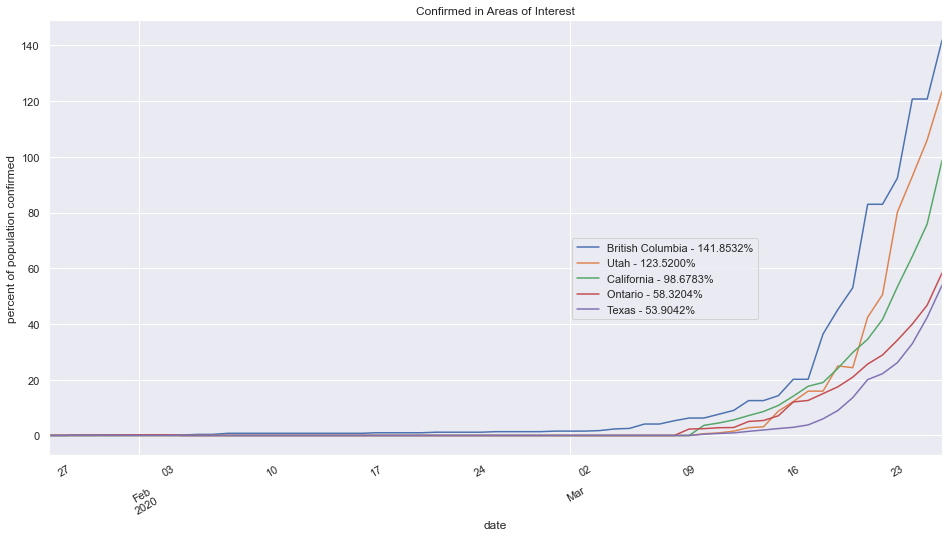

In [12]:
interest = [('US', 'Texas'), ('US', 'Utah'), ('US', 'California'), ('Canada', 'British Columbia'), ('Canada', 'Ontario')]

def f(x):
    if x[0:2] not in interest:
        return False
    
    return True

usa_areas = list(filter(f, usa.columns))
canada_areas = list(filter(f, canada.columns))

u = usa[['Texas', 'Utah', 'California']]
c = canada[['Ontario', 'British Columbia']]

of_interest = pd.DataFrame()
for column in c.columns:
    of_interest[column] = c[column]
for column in u.columns:
    of_interest[column] = u[column]
of_interest = of_interest.fillna(0)

last_date = max(of_interest.index)
last = of_interest.loc[last_date].sort_values(ascending=False).fillna(0)

labels = ["%s - %.4f%%" % v for v in zip(last.index, last.values)]
ax = of_interest[last.index].plot(rot=30, figsize=(16,8), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.8, 0.3))
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass